### CAPM and Fama–French Models: Explanation Specific to This Study

There are two ways to ask the same question: did this portfolio actually perform well, or did it just take on a lot of risk? This notebook works through that question using two asset pricing frameworks CAPM and the FamaFrench 3 Factor Model  applied to a sector based portfolio over the January 2015 to February 2020 period.


### CAPM (Capital Asset Pricing Model)

The simplest version of this question comes from CAPM. The model's premise is that investors only get compensated for one type of risk: exposure to the overall market. Everything else, in theory, can be diversified away. So the test is straightforward regress the portfolio's excess return against the market's excess return:

$$R_p - R_f = \alpha + \beta (R_m - R_f) + \varepsilon$$


In the context of this study, CAPM addresses the following question:

Does the portfolio generate abnormal returns (alpha) after adjusting only for market risk?

* **Beta (β)** measures the sensitivity of the portfolio to market movements.
* **Alpha (α)** represents the average return unexplained by market risk alone.

CAPM often exhibits relatively low explanatory power R² because it ignores other dimensions of systematic risk.


### Fama–French Three-Factor Model

That's where Fama and French come in. Their insight was that two additional factors size and value show up persistently in the data and can't be explained away as noise. The model adds them to CAPM:

$$R_i - R_f = \alpha + \beta_1(R_m - R_f) + \beta_2 \cdot SMB + \beta_3 \cdot HML + \epsilon$$


**SMB (Small Minus Big)** captures the historical tendency of small cap stocks to outperform large-caps over time. A positive SMB loading means the portfolio skews toward smaller companies.


**HML (High Minus Low)** captures the value premium the tendency of cheap, high book to market stocks to outperform expensive growth stocks. A negative HML loading signals a growth tilt.


The key question here is whether alpha survives once these two additional risk factors are controlled for. If it does, that's a stronger case for genuine outperformance. If it shrinks or disappears, it suggests the portfolio's returns were explained by factor exposures all along.

---
**Analysis Period:** January 2015 – February 2020  

In [104]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
tickers = ["ARKK", "SPY"]

start = "2015-1-1"
end = "2020-2-1"

data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
retrn = data.pct_change().dropna()

m_retrn = retrn["ARKK"].resample("ME").agg(lambda x: (x+1).prod()-1)
spy_retrn = retrn["SPY"].resample("ME").agg(lambda x: (x + 1).prod() - 1)

### 1.1 Price Performance

The normalized price chart below gives an immediate sense of how differently ARKK and SPY behaved over this period.

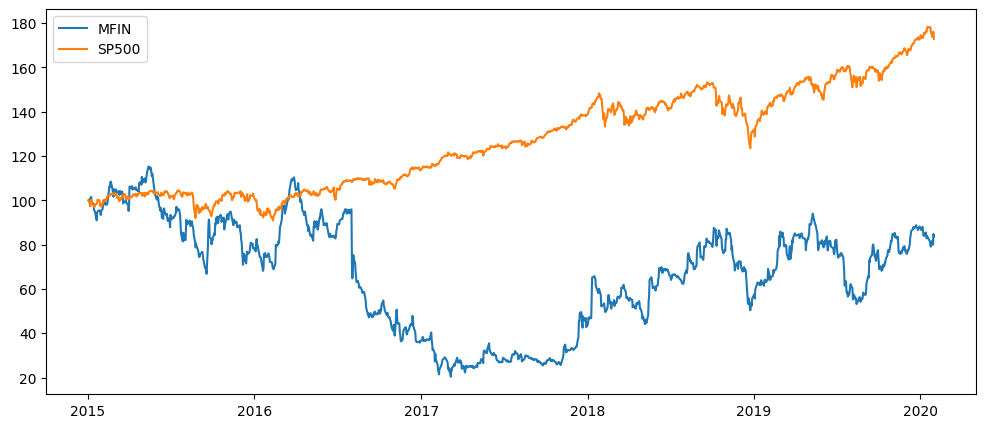

In [ ]:
index = (data/data.iloc[0]) * 100

plt.figure(figsize=(12,5))
plt.plot(index["ARKK"], label="ARKK")
plt.plot(index["SPY"], label="SP500")
plt.legend()

### 1.2 Rolling Correlation

A single correlation number would hide a lot here. The 6-month rolling correlation between ARKK and SPY drops close to zero — and even turns negative — around 2017–2018. This tells us that ARKK was moving largely independently of the market during that stretch, which is unusual for an equity fund.

This instability in the relationship is worth keeping in mind when interpreting the regression results. A fund that periodically decouples from the market will have noisier beta estimates.

Text(0.5, 0, 'Date')

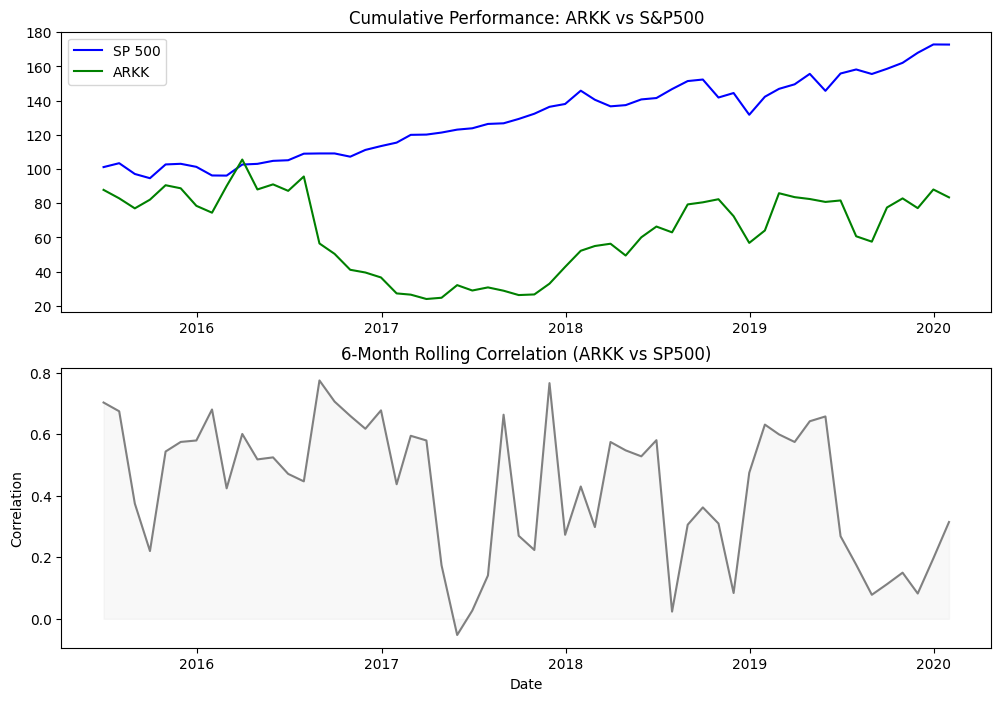

In [116]:
pct = pd.concat([m_retrn, spy_retrn], axis=1)
pct.columns = ["Portfolio", "SPY"]

rolling_corr = pct["Portfolio"].rolling(6).corr(pct["SPY"])

df_norm = pd.DataFrame(index=pct.index)
df_norm["Portfolio"] = (1 + pct["Portfolio"]).cumprod() * 100
df_norm["SPY"] = (1 + pct["SPY"]).cumprod() * 100

df_plot = df_norm.join(rolling_corr.rename("Corr")).dropna()

spy_ret = (df_plot["SPY"].iloc[-1] / df_plot["SPY"].iloc[0] - 1) * 100
port_ret = (df_plot["Portfolio"].iloc[-1] / df_plot["Portfolio"].iloc[0] - 1) * 100

fig,axes = plt.subplots(2,1,figsize=(12,8))

axes[0].plot(df_plot.index, df_plot["SPY"],label="SP 500", color="blue")
axes[0].plot(df_plot.index, df_plot["Portfolio"],label="ARKK", color="green")
axes[0].set_title("Cumulative Performance: ARKK vs S&P500")
axes[0].legend()
axes[1].plot(df_plot.index, df_plot["Corr"], color="grey")
axes[1].fill_between(df_plot.index, df_plot["Corr"], color="lightgrey", alpha=0.15)
axes[1].set_title("6-Month Rolling Correlation (ARKK vs SP500)")
axes[1].set_ylabel("Correlation")
axes[1].set_xlabel("Date")

### 2. Load Fama French Factor

The Fama-French factors are available from Kenneth French's data library:
- **Mkt-RF**: Market excess return (market return - risk-free rate)
- **SMB**: Small Minus Big (size premium)
- **HML**: High Minus Low (value premium)
- **RF**: Risk-free rate

In [117]:
ff = pd.read_excel("/Users/mehmedekinelitog/Desktop/Sample_Data/F-F_Research_Data_Factors.xlsx")
ff.columns = ["Date", "Mkt-RF", "SMB", "HML", "RF"]
ff = ff[ff["Date"].astype(str).str.isnumeric()]
ff["Date"] = pd.to_datetime(ff["Date"].astype(str), format="%Y%m")
ff["Date"] = ff["Date"] + pd.offsets.MonthEnd(0)
ff.set_index("Date", inplace=True)
ff = ff / 100

In [118]:
data = pd.concat([m_retrn,ff], axis=1)
data.tail()

,MFIN,Mkt-RF,SMB,HML,RF
Date,,,,,
2019-09-30,0.347368,0.0141,-0.0097,0.0676,0.0018
2019-10-31,0.068750,0.0207,0.0027,-0.0192,0.0015
2019-11-30,-0.068713,0.0387,0.0072,-0.0200,0.0012
2019-12-31,0.141287,0.0277,0.0076,0.0173,0.0014
2020-01-31,-0.052269,-0.0011,-0.0310,-0.0622,0.0013


In [ ]:
data["Excess_Return"] = data["ARKK"] - data["RF"]

### 3.1 CAPM Interpretation

Key results to examine:
- **Alpha (const):** Is it statistically significant (p < 0.05)? A positive alpha means the fund earns abnormal returns beyond market risk compensation.
- **Beta (Mkt-RF):** Values > 1 indicate the fund is more volatile than the market (aggressive growth tilt is expected for ARKK).
- **R²:** How much of the portfolio's return variation is explained by the market factor alone? Typically 60–80% for diversified equity funds.

In [121]:
y_capm = data["Excess_Return"]
X_capm = sm.add_constant(data["Mkt-RF"])

capm_model = sm.OLS(y_capm, X_capm).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     7.672
Date:                Fri, 20 Feb 2026   Prob (F-statistic):            0.00749
Time:                        07:22:34   Log-Likelihood:                 32.801
No. Observations:                  61   AIC:                            -61.60
Df Residuals:                      59   BIC:                            -57.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.019     -0.269      0.7

### 3.2 Interpreting the CAPM Output

**Beta = 1.59 (p < 0.001)** — ARKK moves about 1.6x the market on average. For every 1% the S&P 500 moves, ARKK moves roughly 1.6% in the same direction. This is consistent with the fund's concentrated, high-conviction style.

**Alpha = 0.0045 (p = 0.456)** — Not statistically significant. On its face, this means CAPM finds no evidence of abnormal performance after accounting for market risk.

But here's where it gets interesting: **R² = 0.608**, meaning about 39% of ARKK's monthly return variance is left unexplained by the market factor alone. That's a large residual. CAPM is probably leaving out something important.

### 4. Fama French 3 Factor Regression

Alpha is not statistically significant. After controlling for market, size and value exposures, there is no statistical evidence of abnormal performance. The R-squared value of 0.73 indicates that a substantial portion of the variation in portfolio excess returns is explained by the Fama French factors, while the remaining variation reflects idiosyncratic shocks captured by the regression residuals.

In [122]:
Y = data["Excess_Return"]

X = data[["Mkt-RF", "SMB", "HML"]]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.762
Date:                Fri, 20 Feb 2026   Prob (F-statistic):             0.0503
Time:                        07:22:41   Log-Likelihood:                 33.212
No. Observations:                  61   AIC:                            -58.42
Df Residuals:                      57   BIC:                            -49.98
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0084      0.020     -0.429      0.6

Text(0.5, 1.0, 'Fama-French Model')

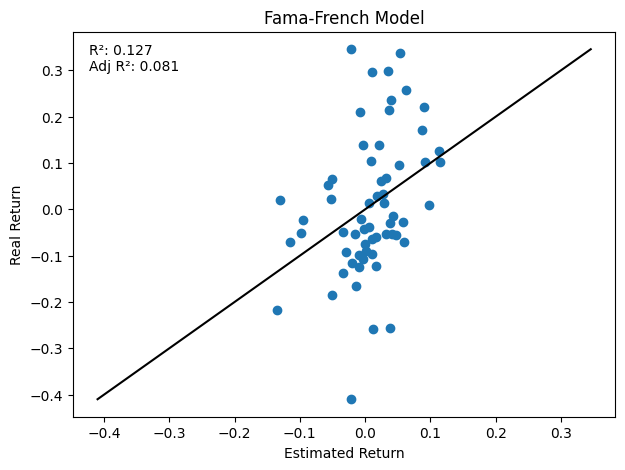

In [123]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(model.fittedvalues, Y)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color="black")
ax.text(0.03, 0.97, f"R²: {model.rsquared:.3f}\nAdj R²: {model.rsquared_adj:.3f}", transform=ax.transAxes, verticalalignment="top")
ax.set_xlabel("Estimated Return")
ax.set_ylabel("Real Return")
ax.set_title("Fama-French Model")